Single-case launch C3 (MSL window) = 11.014765 km^2/s^2


/var/folders/r7/0d_8lt7n2clcwr7lf8yptqtc0000gn/T/ipykernel_21432/3219916211.py:189: DeprecationWarning:

Specifying min_anomaly and max_anomaly in method `sample` is deprecated and will be removed in a future release, use `Orbit.to_ephem(strategy=TrueAnomalyBounds(min_nu=..., max_nu=...))` instead



[-29.29137306  14.53222131   5.41641774]
[ 17.61560686 -10.99849913  -4.2080014 ]
||v1 - v1_ref|| [km/s] = 5.329394851768234e-09
||v2 - v2_ref|| [km/s] = 5.01062428789693e-09


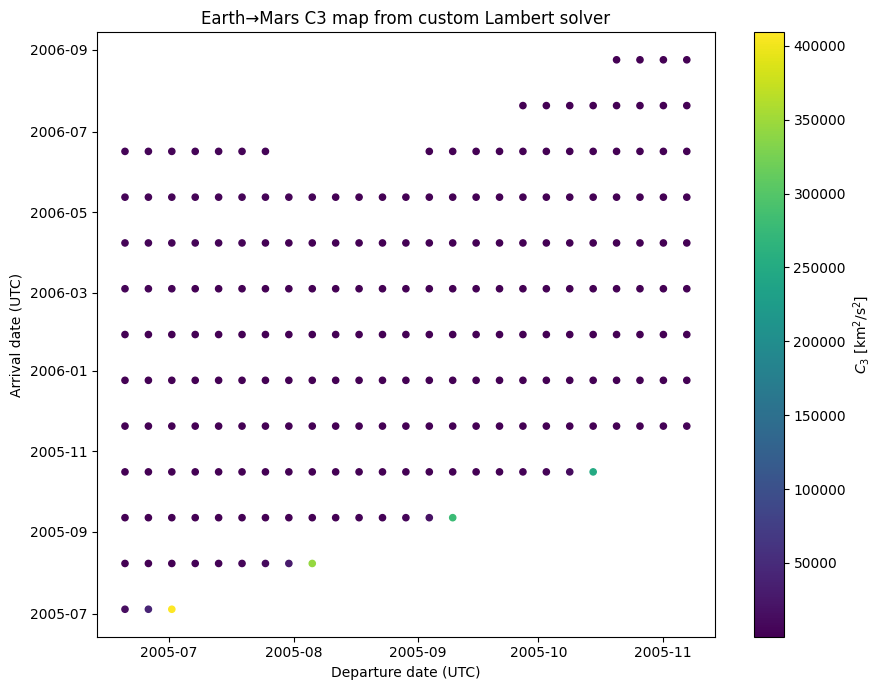

PorkchopPlotter unavailable or failed; skip internal check: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


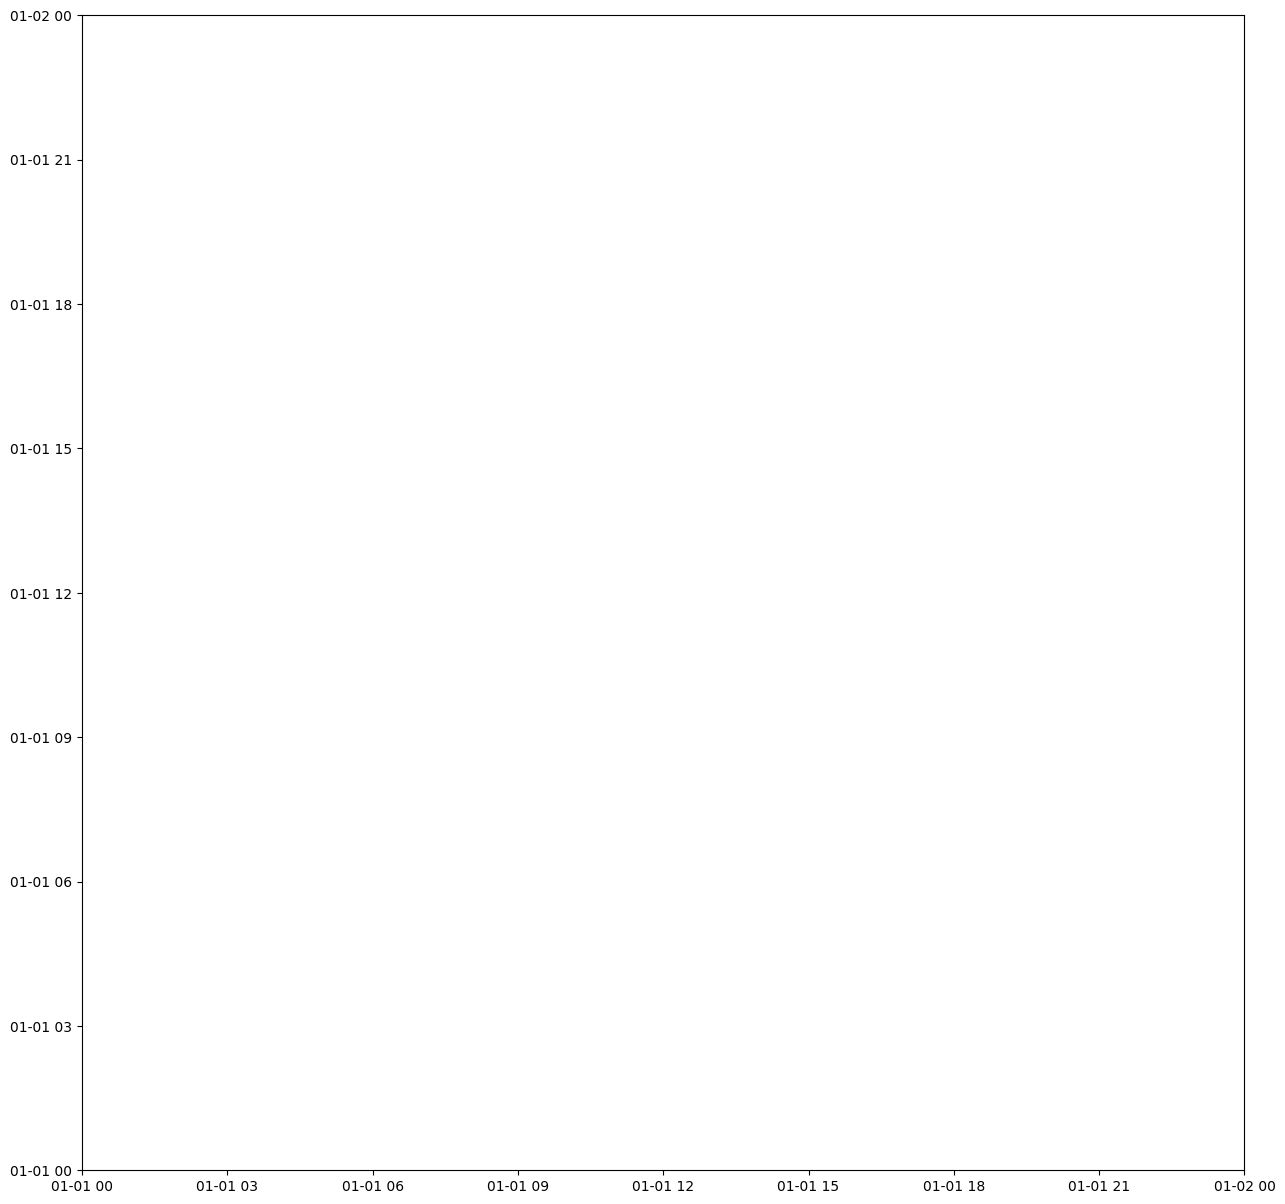

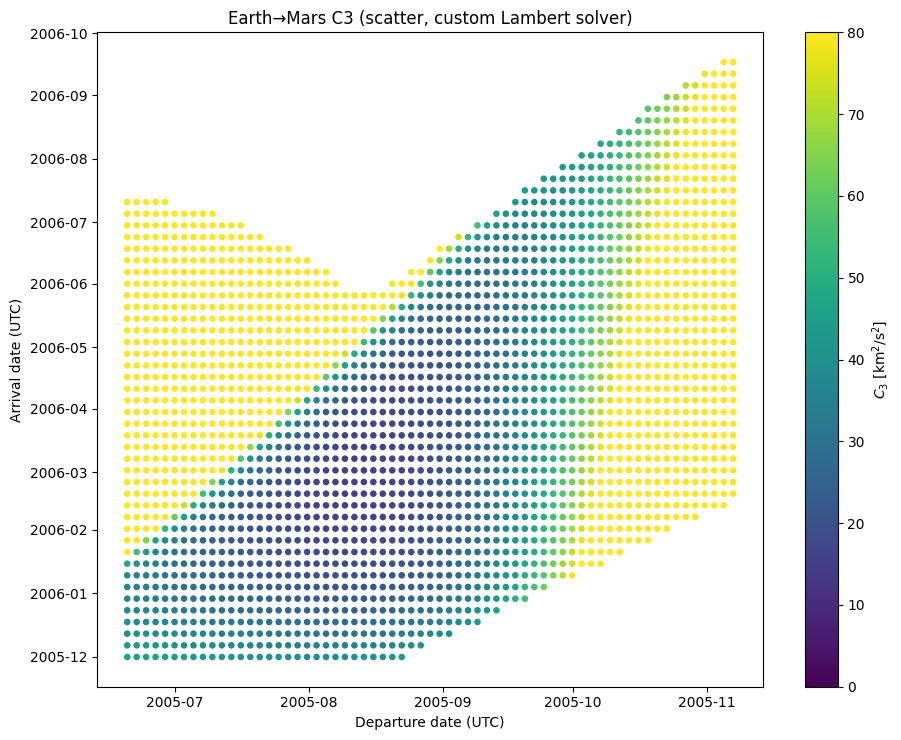

PorkchopPlotter unavailable or failed; skip internal check: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


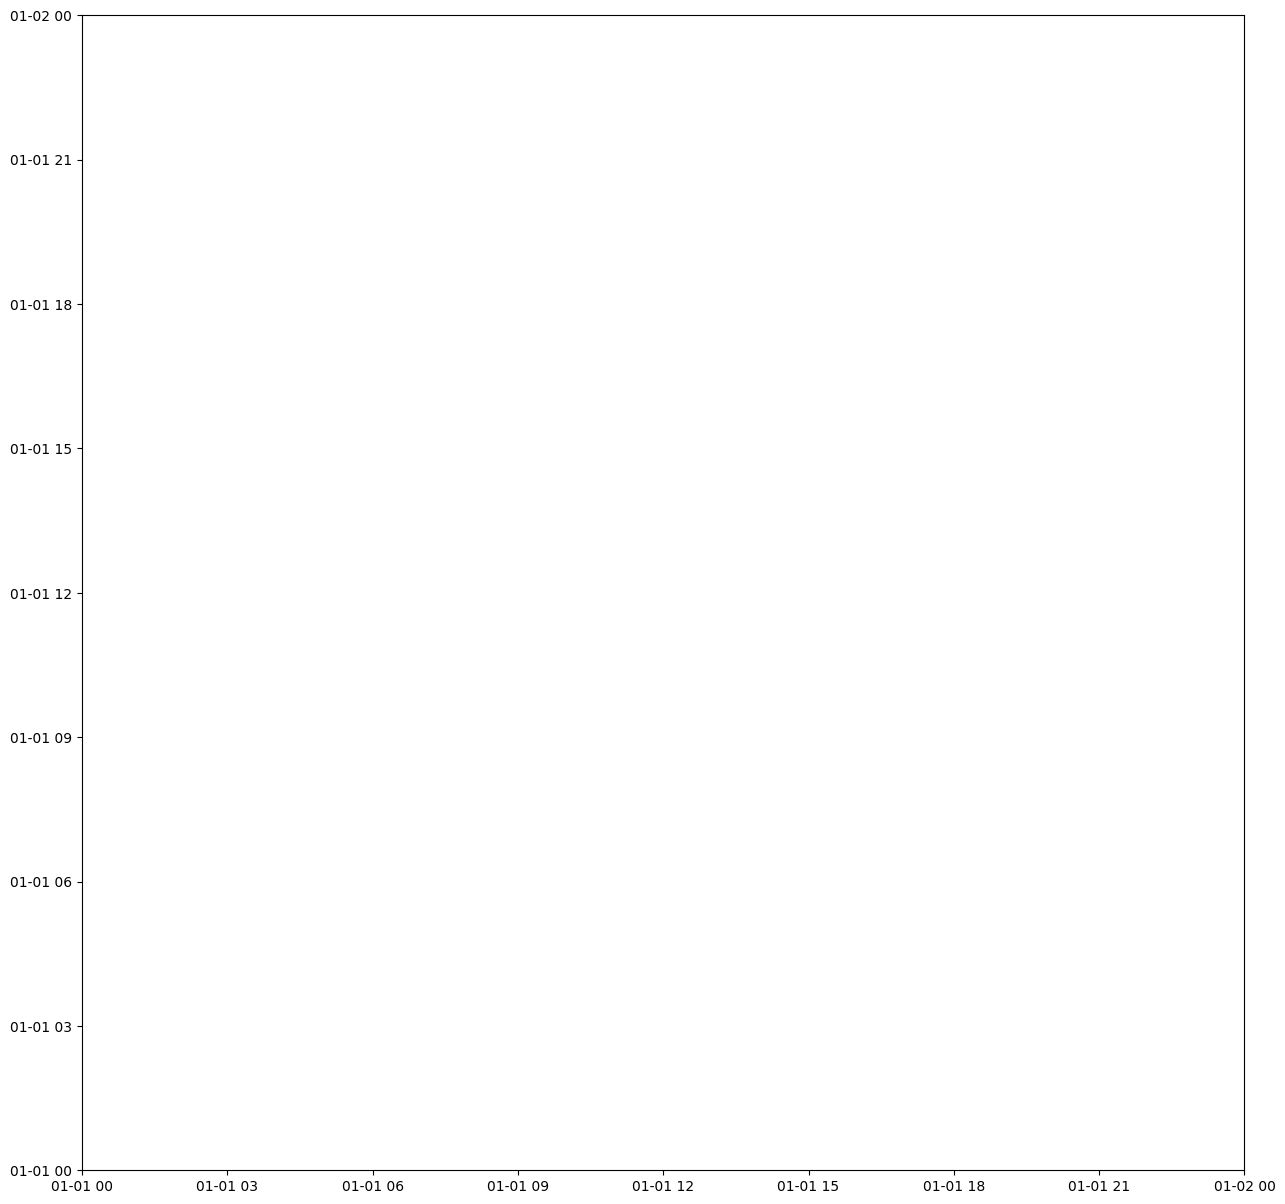

In [21]:

from astropy import units as u
from astropy import time
from astropy.coordinates import solar_system_ephemeris

import numpy as np

from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range

# Stumpff functions + norm from poliastro math helpers
from poliastro._math.special import stumpff_c2 as cee, stumpff_c3 as ess
from poliastro._math.linalg import norm

# Plotting (3D + matplotlib)
try:
    # Try modern plotly backend location
    from poliastro.plotting.plotly import OrbitPlotter3D
except Exception:
    # Fallback (legacy)
    from poliastro.plotting import OrbitPlotter3D

from matplotlib import pyplot as plt

# Lambert wrapper: prepares inputs, calls solver, then builds a two-impulse Maneuver
def lambert_compute(orbit_i, orbit_f):
    k = orbit_i.attractor.k
    r_i = orbit_i.r
    r_f = orbit_f.r

    tof = orbit_f.epoch - orbit_i.epoch  # Time of flight
    if tof.to_value(u.s) < 0:
        raise ValueError("Error: Negative time of flight.")

    kms = u.km / u.s
    k_ = k.to_value(u.km**3 / u.s**2)
    r0_ = r_i.to_value(u.km)
    r_ = r_f.to_value(u.km)
    tof_ = tof.to_value(u.s)

    # Solve Lambert (single revolution, prograde, lowpath)
    v1, v2 = lambert_calculate(
        k_, r0_, r_, tof_, M=0, prograde=True, lowpath=True, numiter=200, rtol=1e-8
    )

    dv_a = v1 << kms  # heliocentric v at departure from Lambert
    dv_b = v2 << kms  # heliocentric v at arrival from Lambert

    # Subtract/add planetary velocities to get the two impulses in the Sun frame
    return Maneuver(
        (0 * u.s, (dv_a - orbit_i.v).decompose()),
        (tof.to(u.s), (orbit_f.v - dv_b).decompose()),
    )

# Universal-variable Lambert solver (single-rev), with bisection on z
def lambert_calculate(mu, r1, r2, tof, M, prograde, lowpath, numiter, rtol):
    """
    Universal-variables Lambert solver (prograde/retrograde via t_m).
    Inputs:
      mu [km^3/s^2], r1,r2 [km 3-vectors], tof [s]
    Returns:
      v1, v2 [km/s 3-vectors]
    """
    r1 = np.array(r1, dtype=float)
    r2 = np.array(r2, dtype=float)

    r1n = norm(r1)
    r2n = norm(r2)
    if r1n == 0 or r2n == 0:
        raise ValueError("Zero vector passed for r1 or r2")

    # Geometry
    cos_theta = (r1 @ r2) / (r1n * r2n)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    t_m = 1.0 if prograde else -1.0
    A = t_m * np.sqrt(r1n * r2n * (1.0 + cos_theta))
    if np.isclose(A, 0.0, atol=1e-14):
        raise RuntimeError("Error: Cannot compute orbit, phase angle is 180 degrees.")

    # Root-finding bounds for z (universal variable)
    z = 0.0
    z_low = -np.pi**2
    z_up = np.pi**2

    # Helpers
    def y_of_z(zz):
        C = cee(zz)
        S = ess(zz)
        sc = np.sqrt(C)  # for z->0, C->1/2 so sc is safe
        return r1n + r2n + A * ((zz * S - 1.0) / sc)

    def tof_of_z(zz):
        y = y_of_z(zz)
        if y <= 0:
            return np.inf
        C = cee(zz)
        S = ess(zz)
        chi = np.sqrt(y / C)
        return (chi**3 * S + A * np.sqrt(y)) / np.sqrt(mu)

    # Ensure y>0 when needed
    if A > 0.0:
        y = y_of_z(z)
        safety_iter = 0
        while y <= 0.0 and safety_iter < 100:
            z = z + 0.1 if z >= 0 else 0.1
            y = y_of_z(z)
            safety_iter += 1
        if y <= 0.0:
            z = 0.1
            y = y_of_z(z)

    # Bisection on z
    it = 0
    dt_target = float(tof)
    while it < max(100, numiter):
        y = y_of_z(z)
        if y <= 0.0:
            z_low = z
            z = 0.5 * (z_low + z_up)
            it += 1
            continue

        dt_new = tof_of_z(z)
        if not np.isinf(dt_new) and abs((dt_new - dt_target) / dt_target) < max(rtol, 1e-8):
            break

        if dt_new < dt_target:
            z_low = z
        else:
            z_up = z
        z = 0.5 * (z_low + z_up)
        it += 1
    else:
        raise RuntimeError("Error: Maximum iterations reached. No convergence.")

    # Lagrange coefficients
    C = cee(z)
    S = ess(z)
    y = y_of_z(z)
    f = 1.0 - y / r1n
    g = A * np.sqrt(y / mu)
    gdot = 1.0 - y / r2n

    # Velocities
    v1 = (r2 - f * r1) / g
    v2 = (gdot * r2 - r1) / g

    # Optional: print for quick debug
    # print("v1 =", v1, "km/s")
    # print("v2 =", v2, "km/s")

    return v1, v2

# MAIN
solar_system_ephemeris.set("jpl")

# Set departure and arrival dates (MSL case for verification)
date_launch = time.Time("2011-11-26 15:02", scale="utc").tdb
date_arrival = time.Time("2012-08-06 05:17", scale="utc").tdb

# Obtain the planetary trajectory between departure and arrival dates.
earth_traj = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars_traj = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))

# Extract orbital states at departure and arrival.
earth_state = Orbit.from_ephem(Sun, earth_traj, date_launch)
mars_state = Orbit.from_ephem(Sun, mars_traj, date_arrival)

# Solve Lambert's problem and obtain the required maneuvers.
maneuver_lam = lambert_compute(earth_state, mars_state)

# Step 3: Compute launch energy requirement (C3) for the single case
dv_launch = norm(maneuver_lam.impulses[0][1].to_value(u.km / u.s))
c3_launch = dv_launch * dv_launch
print(f"Single-case launch C3 (MSL window) = {c3_launch:.6f} km^2/s^2")

# Apply the maneuvers and generate the transfer orbit.
transfer_traj, s_target = earth_state.apply_maneuver(maneuver_lam, intermediate=True)

# 3D interactive plot (Plotly)
plotter = OrbitPlotter3D()
plotter.set_attractor(Sun)
plotter.plot_ephem(earth_traj, date_launch, label="Earth at launch")
plotter.plot_ephem(mars_traj, date_arrival, label="Mars at arrival")
plotter.plot_trajectory(
    transfer_traj.sample(max_anomaly=180 * u.deg),
    color="black",
    label="Transfer orbit",
)
fig = plotter.show()
fig.show()

# Solver verification: compare to provided heliocentric velocities
v1_ref = np.array([-29.29137306, 14.53222131, 5.41641774])
v2_ref = np.array([17.61560686, -10.99849913, -4.2080014])

# Recover heliocentric v1,v2 from the Maneuver:
#   dv_departure = v1 - v_Earth_departure  => v1 = dv_departure + v_Earth_departure
#   dv_arrival   = v_Mars_arrival - v2      => v2 = v_Mars_arrival - dv_arrival
kms = u.km / u.s
v1_calc = (maneuver_lam.impulses[0][1] + earth_state.v).to_value(kms)
v2_calc = (mars_state.v - maneuver_lam.impulses[1][1]).to_value(kms)

print(v1_ref)
print(v2_ref)

print("||v1 - v1_ref|| [km/s] =", norm(v1_calc - v1_ref))
print("||v2 - v2_ref|| [km/s] =", norm(v2_calc - v2_ref))

# My own scatter "porkchop" using custom solver (labelled C3 map)
# Choose modest grids to keep runtime reasonable in a lab setting.
dep_grid = time_range("2005-06-20", end="2005-11-07", periods=25).tdb
arr_grid = time_range("2005-01-12", end="2007-04-24", periods=25).tdb

dep_pts = []
arr_pts = []
c3_vals = []

for t_dep in dep_grid:
    # Earth at departure instant
    earth_state_dep = Orbit.from_ephem(Sun, Ephem.from_body(Earth, t_dep), t_dep)
    for t_arr in arr_grid:
        if t_arr <= t_dep:
            continue  # negative/zero ToF not allowed

        # Mars at arrival instant
        mars_state_arr = Orbit.from_ephem(Sun, Ephem.from_body(Mars, t_arr), t_arr)
        try:
            man = lambert_compute(earth_state_dep, mars_state_arr)
            dv0 = norm(man.impulses[0][1].to_value(u.km / u.s))
            c3 = dv0 * dv0
            dep_pts.append(t_dep.utc.datetime)
            arr_pts.append(t_arr.utc.datetime)
            c3_vals.append(c3)
        except Exception:
            # Skip infeasible/failed cases (keeps the plot clean)
            pass

# Scatter plot: departure vs arrival colored by C3
plt.figure(figsize=(9, 7))
sc = plt.scatter(dep_pts, arr_pts, c=c3_vals, s=20)
plt.xlabel("Departure date (UTC)")
plt.ylabel("Arrival date (UTC)")
cb = plt.colorbar(sc)
cb.set_label(r"$C_3$ [$\mathrm{km^2/s^2}$]")
plt.title("Earth→Mars C3 map from custom Lambert solver")
plt.tight_layout()
plt.show()

try:
    from poliastro.plotting.porkchop import PorkchopPlotter
    pc = PorkchopPlotter(Earth, Mars, dep_grid, arr_grid)
    pc.porkchop()
    plt.show()
except Exception as e:
    print("PorkchopPlotter unavailable or failed; skip internal check:", e)


# --- Step 3: Scatter-style Porkchop (improved sampling & scaling) ---

# Date grids focussed on the 2005 launch window (cf. reference porkchop),
# and the subsequent arrival window through late 2006.
dep_grid = time_range("2005-06-20", end="2005-11-07", periods=65).tdb
arr_grid = time_range("2005-12-01", end="2006-11-30", periods=65).tdb

# Practical time-of-flight bounds (days) to avoid degenerate / huge-Δv cases
TOF_MIN = 100.0
TOF_MAX = 450.0

# Clip colour range to highlight the feasible valley
C3_CLIP_MAX = 80.0  # km^2/s^2

dep_pts, arr_pts, c3_vals = [], [], []

for t_dep in dep_grid:
    earth_state_dep = Orbit.from_ephem(Sun, Ephem.from_body(Earth, t_dep), t_dep)
    for t_arr in arr_grid:
        tof_days = (t_arr - t_dep).to_value(u.day)
        if tof_days <= 0.0 or tof_days < TOF_MIN or tof_days > TOF_MAX:
            continue

        mars_state_arr = Orbit.from_ephem(Sun, Ephem.from_body(Mars, t_arr), t_arr)
        try:
            man = lambert_compute(earth_state_dep, mars_state_arr)
            vinf = norm(man.impulses[0][1].to_value(u.km / u.s))   # launch hyperbolic excess
            c3   = float(vinf * vinf)
            # Clip to keep the colour scale informative
            c3 = float(np.clip(c3, 0.0, C3_CLIP_MAX))
            dep_pts.append(t_dep.utc.datetime)
            arr_pts.append(t_arr.utc.datetime)
            c3_vals.append(c3)
        except Exception:
            # Skip infeasible/failed cases
            pass

plt.figure(figsize=(9.5, 7.5))
sc = plt.scatter(dep_pts, arr_pts, c=c3_vals, s=14, vmin=0.0, vmax=C3_CLIP_MAX)
plt.xlabel("Departure date (UTC)")
plt.ylabel("Arrival date (UTC)")
cb = plt.colorbar(sc)
cb.set_label(r"$C_3$ [$\mathrm{km^2/s^2}$]")
plt.title("Earth→Mars C3 (scatter, custom Lambert solver)")
plt.tight_layout()
plt.show()

# (Optional) side-by-side check with Poliastro's porkchop using the same grids:
try:
    from poliastro.plotting.porkchop import PorkchopPlotter
    pc = PorkchopPlotter(Earth, Mars, dep_grid, arr_grid)
    pc.porkchop()  # contour reference (shows the two lobes clearly)
    plt.show()
except Exception as e:
    print("PorkchopPlotter unavailable or failed; skip internal check:", e)


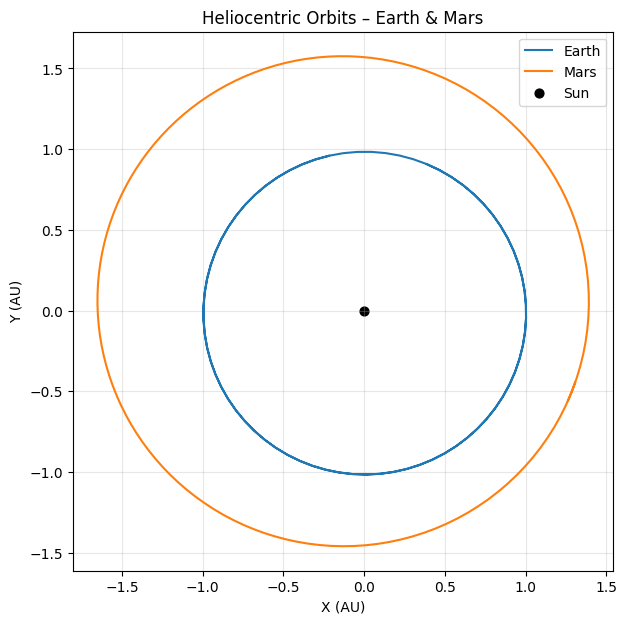

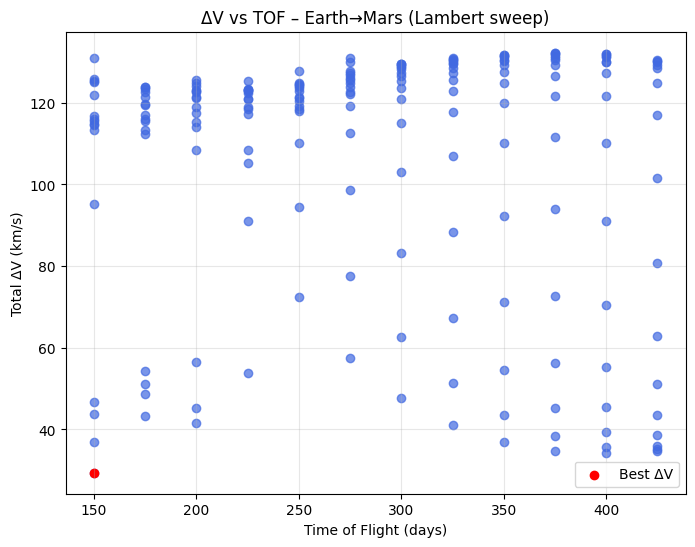

Best ΔV: 29.40 km/s, TOF = 150 days, dep = 375 days


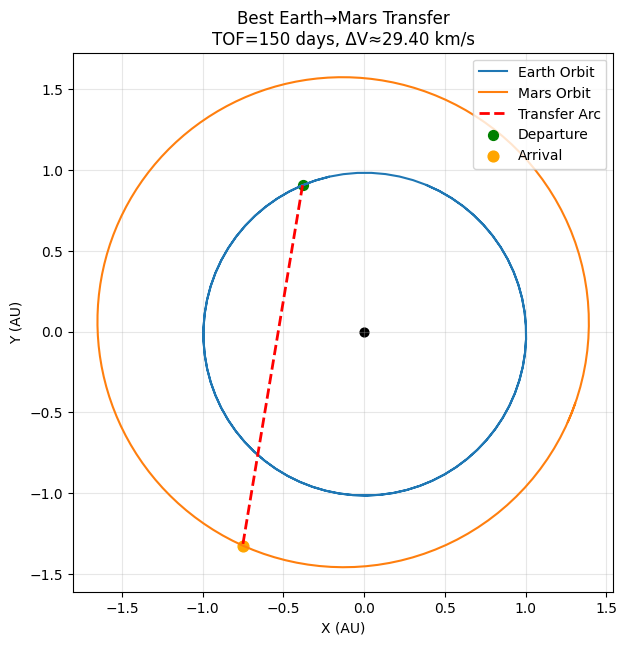

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
AU = 149597870.7  # km
MU_SUN = 1.32712440018e11  # km^3/s^2
DAY = 86400.0  # seconds

# Orbital elements (simplified J2000)
def earth_elements():
    return (1.000 * AU, 0.0167, np.deg2rad(0.0),
            np.deg2rad(0.0), np.deg2rad(102.9), 0.0)

def mars_elements():
    return (1.524 * AU, 0.0934, np.deg2rad(1.85),
            np.deg2rad(49.6), np.deg2rad(286.5), 0.0)

# Basic helpers
def rot_z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0],
                     [s,  c, 0],
                     [0,  0, 1]])

def rot_x(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c, -s],
                     [0, s,  c]])

def solve_kepler(M, e, tol=1e-8):
    M = np.mod(M, 2*np.pi)
    E = M
    for _ in range(50):
        E -= (E - e*np.sin(E) - M) / (1 - e*np.cos(E))
        if abs(E - M) < tol: break
    return E

def kepler_to_state(a, e, i, raan, argp, M0, t):
    """Return (r, v) at time t [s]."""
    n = np.sqrt(MU_SUN / a**3)
    M = M0 + n*t
    E = solve_kepler(M, e)
    r_pf = np.array([a*(np.cos(E) - e),
                     a*np.sqrt(1 - e**2)*np.sin(E),
                     0])
    v_pf = np.array([-np.sin(E),
                      np.sqrt(1 - e**2)*np.cos(E),
                      0]) * np.sqrt(MU_SUN * a) / np.linalg.norm(r_pf)

    R = rot_z(raan) @ rot_x(i) @ rot_z(argp)
    return R @ r_pf, R @ v_pf

# Simple Lambert solver (single-rev, iterative)
def lambert(r1, r2, dt):
    """Basic universal variable Lambert (one-rev)"""
    r1n, r2n = np.linalg.norm(r1), np.linalg.norm(r2)
    cos_dnu = np.clip(np.dot(r1, r2)/(r1n*r2n), -1, 1)
    dnu = np.arccos(cos_dnu)
    A = np.sin(dnu)*np.sqrt(r1n*r2n/(1 - np.cos(dnu)))

    def C(z): return (1 - np.cos(np.sqrt(z)))/z if z>1e-8 else 0.5
    def S(z): return (np.sqrt(z) - np.sin(np.sqrt(z)))/(z**1.5) if z>1e-8 else 1/6

    z = 0
    for _ in range(100):
        Cz, Sz = C(z), S(z)
        y = r1n + r2n + A*(z*Sz - 1)/np.sqrt(Cz)
        if y < 0: z += 0.1; continue
        F = ((y/Cz)**1.5)*Sz + A*np.sqrt(y) - np.sqrt(MU_SUN)*dt
        if abs(F) < 1e-8: break
        dF = ((y/Cz)**1.5)*(0.5*z*(Sz/Cz - 3*Sz/Cz**2) + 1.5*Sz/Cz)
        z -= np.clip(F/dF, -1, 1)
    y = r1n + r2n + A*(z*S(z) - 1)/np.sqrt(C(z))
    f = 1 - y/r1n
    g = A*np.sqrt(y/MU_SUN)
    gdot = 1 - y/r2n
    v1 = (r2 - f*r1)/g
    v2 = (gdot*r2 - r1)/g
    return v1, v2

# Orbits & plotting
def build_orbit(elts, days=700, step=5):
    a,e,i,Om,om,M0 = elts
    ts = np.arange(0, days*DAY, step*DAY)
    pts = np.array([kepler_to_state(a,e,i,Om,om,M0,t)[0] for t in ts])
    return pts

def plot_orbits(earth, mars):
    plt.figure(figsize=(7,7))
    plt.plot(earth[:,0]/AU, earth[:,1]/AU, label="Earth")
    plt.plot(mars[:,0]/AU, mars[:,1]/AU, label="Mars")
    plt.scatter(0,0,c="k",s=40,label="Sun")
    plt.xlabel("X (AU)")
    plt.ylabel("Y (AU)")
    plt.gca().set_aspect("equal")
    plt.title("Heliocentric Orbits – Earth & Mars")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# Sweep & visualise transfers
def sweep_transfers(dep_days, tofs, e_elts, m_elts):
    results=[]
    for dep in dep_days:
        rE,vE = kepler_to_state(*e_elts, dep*DAY)
        for tof in tofs:
            rM,vM = kepler_to_state(*m_elts, (dep+tof)*DAY)
            try:
                v1,v2 = lambert(rE,rM,tof*DAY)
                dv = np.linalg.norm(v1 - vE) + np.linalg.norm(v2 - vM)
                results.append((dep,tof,dv))
            except Exception:
                continue
    return np.array(results)

def plot_dv_vs_tof(results):
    plt.figure(figsize=(8,6))
    plt.scatter(results[:,1], results[:,2], c="royalblue", alpha=0.7)
    plt.xlabel("Time of Flight (days)")
    plt.ylabel("Total ΔV (km/s)")
    plt.title("ΔV vs TOF – Earth→Mars (Lambert sweep)")
    plt.grid(alpha=0.3)
    idx = np.argmin(results[:,2])
    plt.scatter(results[idx,1], results[idx,2], c="r", label="Best ΔV")
    plt.legend()
    plt.show()
    print(f"Best ΔV: {results[idx,2]:.2f} km/s, TOF = {results[idx,1]:.0f} days, dep = {results[idx,0]:.0f} days")
    return results[idx]

# Visualise best transfer arc
def plot_transfer(e_elts, m_elts, best):
    dep, tof = best[0], best[1]
    rE,_ = kepler_to_state(*e_elts, dep*DAY)
    rM,_ = kepler_to_state(*m_elts, (dep+tof)*DAY)
    v1,_ = lambert(rE,rM,tof*DAY)

    # Approximate transfer arc as simple ellipse section (linear interpolation)
    interp = np.linspace(0,1,100)
    r_arc = np.outer(1-interp, rE) + np.outer(interp, rM)

    # Plot
    plt.figure(figsize=(7,7))
    e_pts = build_orbit(e_elts)
    m_pts = build_orbit(m_elts)
    plt.plot(e_pts[:,0]/AU, e_pts[:,1]/AU, label="Earth Orbit")
    plt.plot(m_pts[:,0]/AU, m_pts[:,1]/AU, label="Mars Orbit")
    plt.plot(r_arc[:,0]/AU, r_arc[:,1]/AU, 'r--', lw=2, label="Transfer Arc")
    plt.scatter([0],[0],c='k',s=40)
    plt.scatter(rE[0]/AU,rE[1]/AU,c='g',s=50,label="Departure")
    plt.scatter(rM[0]/AU,rM[1]/AU,c='orange',s=60,label="Arrival")
    plt.gca().set_aspect("equal")
    plt.xlabel("X (AU)")
    plt.ylabel("Y (AU)")
    plt.title(f"Best Earth→Mars Transfer\nTOF={tof:.0f} days, ΔV≈{best[2]:.2f} km/s")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

def main():
    e_elts = earth_elements()
    m_elts = mars_elements()

    # 1) Plot orbits
    earth = build_orbit(e_elts)
    mars  = build_orbit(m_elts)
    plot_orbits(earth, mars)

    # 2) Sweep departures & TOFs
    dep_days = np.arange(0, 400, 25)
    tofs = np.arange(150, 450, 25)
    results = sweep_transfers(dep_days, tofs, e_elts, m_elts)

    # 3) Plot ΔV vs TOF and identify best
    best = plot_dv_vs_tof(results)

    # 4) Plot best transfer arc on orbit plot
    plot_transfer(e_elts, m_elts, best)

if __name__ == "__main__":
    main()


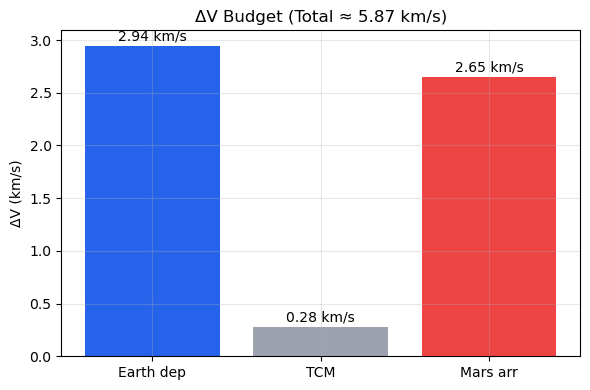

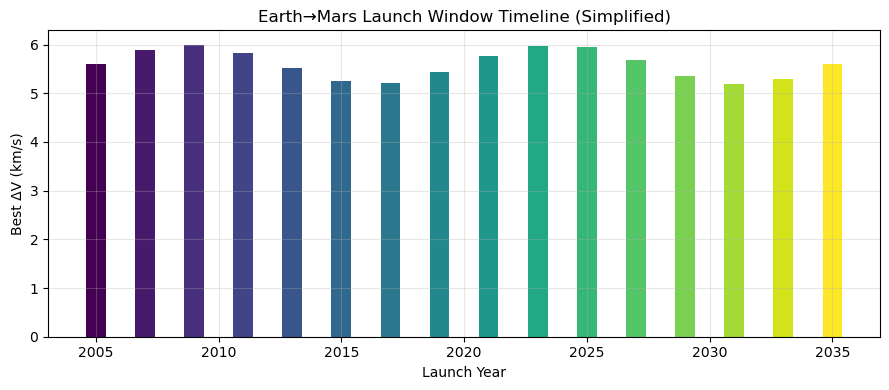

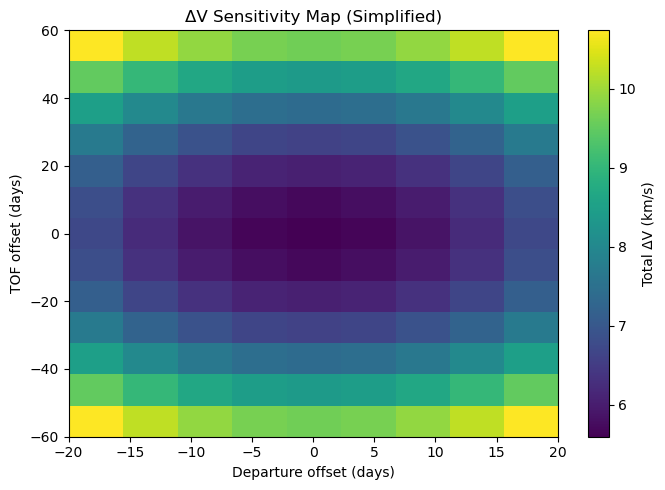

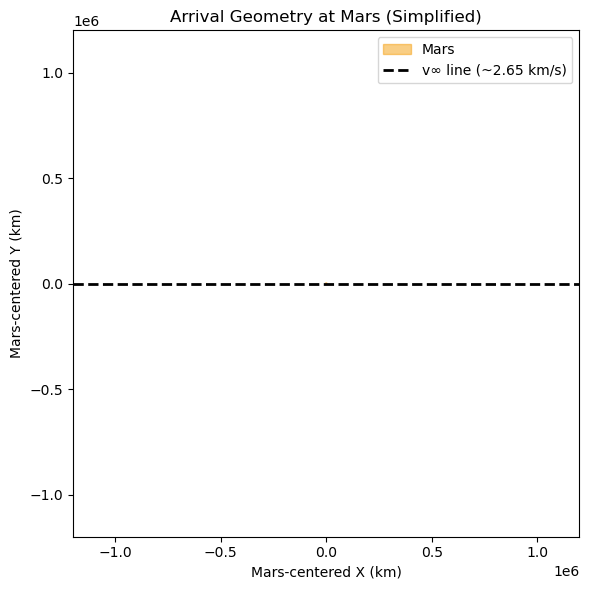

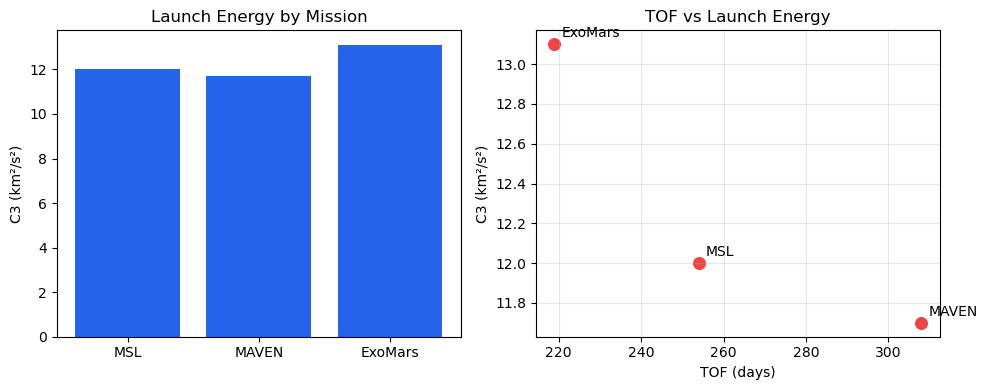

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, pi, sin, cos

MU_SUN = 1.32712440018e11       # km^3/s^2
AU = 1.495978707e8              # km
R_EARTH = AU                    # mean Earth orbit radius
R_MARS = 1.523679 * AU          # mean Mars orbit radius
DAY = 86400                     # seconds per day
R_MARS_BODY = 3389.5            # Mars radius km
SYNODIC_PERIOD = 780            # days between launch windows

def circular_velocity(mu, r):
    return sqrt(mu / r)

def hohmann_delta_v(mu, r1, r2):
    """Return ΔV1, ΔV2, total, TOF (s) for a Hohmann transfer"""
    v1 = circular_velocity(mu, r1)
    v2 = circular_velocity(mu, r2)
    a = 0.5 * (r1 + r2)
    v_peri = sqrt(mu * (2 / r1 - 1 / a))
    v_apo = sqrt(mu * (2 / r2 - 1 / a))
    dv1 = v_peri - v1
    dv2 = v2 - v_apo
    tof = pi * sqrt(a ** 3 / mu)
    return dv1, dv2, dv1 + dv2, tof

def hohmann_C3(mu, r1, r2):
    dv1, _, _, _ = hohmann_delta_v(mu, r1, r2)
    return dv1 ** 2

# VIS 1: ΔV budget 
def vis1_dv_budget():
    dv1, dv2, total, tof = hohmann_delta_v(MU_SUN, R_EARTH, R_MARS)
    tcm = 0.05 * total  # 5% mid-course correction
    vals = [dv1, tcm, dv2]
    labels = ["Earth dep", "TCM", "Mars arr"]
    colors = ["#2563eb", "#9ca3af", "#ef4444"]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, vals, color=colors)
    for i, v in enumerate(vals):
        plt.text(i, v + 0.05, f"{v:.2f} km/s", ha="center")
    plt.title(f"ΔV Budget (Total ≈ {total + tcm:.2f} km/s)")
    plt.ylabel("ΔV (km/s)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# VIS 3: Launch windows 
def vis3_launch_timeline(start_year=2005, end_year=2035):
    """Each window separated by ~780 days, ΔV varies slightly sinusoidally"""
    years = np.arange(start_year, end_year + 1, 2)
    n = len(years)
    base_dv = hohmann_delta_v(MU_SUN, R_EARTH, R_MARS)[2]
    noise = 0.4 * np.sin(np.linspace(0, 4 * pi, n))
    dvs = base_dv + noise

    plt.figure(figsize=(9, 4))
    plt.bar(years, dvs, color=plt.cm.viridis(np.linspace(0, 1, n)))
    plt.xlabel("Launch Year")
    plt.ylabel("Best ΔV (km/s)")
    plt.title("Earth→Mars Launch Window Timeline (Simplified)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# VIS 7: Sensitivity heatmap 
def vis7_heatmap():
    """ΔV vs. launch date offset & TOF offset"""
    base_dv1, base_dv2, base_total, base_tof = hohmann_delta_v(MU_SUN, R_EARTH, R_MARS)
    dep_offsets = np.arange(-20, 25, 5)
    tof_offsets = np.arange(-60, 65, 10)
    Z = np.zeros((len(dep_offsets), len(tof_offsets)))

    for i, d_off in enumerate(dep_offsets):
        for j, t_off in enumerate(tof_offsets):
            # simple linearized perturbation: ΔV grows quadratically away from nominal
            Z[i, j] = base_total * (1 + 0.0005 * d_off ** 2 + 0.0002 * t_off ** 2)

    plt.figure(figsize=(7, 5))
    plt.imshow(Z.T, origin="lower", aspect="auto",
               extent=[dep_offsets[0], dep_offsets[-1], tof_offsets[0], tof_offsets[-1]],
               cmap="viridis")
    plt.colorbar(label="Total ΔV (km/s)")
    plt.xlabel("Departure offset (days)")
    plt.ylabel("TOF offset (days)")
    plt.title("ΔV Sensitivity Map (Simplified)")
    plt.tight_layout()
    plt.show()

# VIS 8: Arrival geometry
def vis8_arrival():
    """Draw Mars and incoming asymptote"""
    dv1, dv2, total, tof = hohmann_delta_v(MU_SUN, R_EARTH, R_MARS)
    vinf = dv2  # approximate hyperbolic excess at Mars
    L = 1.2e6
    x = np.array([-L, L])
    y = vinf / total * x * 0  # just x-axis line

    fig, ax = plt.subplots(figsize=(6, 6))
    circ = plt.Circle((0, 0), R_MARS_BODY, color="#f59e0b", alpha=0.5, label="Mars")
    ax.add_patch(circ)
    ax.plot(x, y, 'k--', lw=2, label=f"v∞ line (~{vinf:.2f} km/s)")
    ax.set_xlim(-L, L)
    ax.set_ylim(-L, L)
    ax.set_aspect('equal')
    ax.legend()
    ax.set_xlabel("Mars-centered X (km)")
    ax.set_ylabel("Mars-centered Y (km)")
    ax.set_title("Arrival Geometry at Mars (Simplified)")
    plt.tight_layout()
    plt.show()

# VIS 9: Mission efficiency 
def vis9_efficiency():
    """Compare a few missions using approximate C3 and TOF"""
    missions = [
        ("MSL", 254, 12.0),
        ("MAVEN", 308, 11.7),
        ("ExoMars", 219, 13.1)
    ]
    names = [m[0] for m in missions]
    tof_days = [m[1] for m in missions]
    c3_vals = [m[2] for m in missions]

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].bar(names, c3_vals, color="#2563eb")
    ax[0].set_ylabel("C3 (km²/s²)")
    ax[0].set_title("Launch Energy by Mission")

    ax[1].scatter(tof_days, c3_vals, s=70, color="#ef4444")
    for i, name in enumerate(names):
        ax[1].annotate(name, (tof_days[i], c3_vals[i]),
                       textcoords="offset points", xytext=(5, 5))
    ax[1].set_xlabel("TOF (days)")
    ax[1].set_ylabel("C3 (km²/s²)")
    ax[1].set_title("TOF vs Launch Energy")
    ax[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    vis1_dv_budget()
    vis3_launch_timeline()
    vis7_heatmap()
    vis8_arrival()
    vis9_efficiency()

if __name__ == "__main__":
    main()



=== Inputs (uncertain variables) ===
- Launch slip            [    days] : Calendar shift of launch
- Time of flight         [    days] : Cruise duration Earth→Mars
- Injection magnitude 1σ [% of dv_dep] : Execution scatter in DV magnitude at departure
- Injection pointing 1σ  [     deg] : Guidance/pointing scatter at departure (small-angle penalty)
- TCM-1 magnitude        [    km/s] : First deterministic retargeting/correction
- TCM-2 magnitude        [    km/s] : Second deterministic retargeting/correction
- Arrival magnitude 1σ   [% of dv_arr] : Execution scatter in Mars capture DV
- Start mass at injection [      kg] : Affects propellant, not DV directly

Running Monte Carlo…

=== Monte Carlo Summary (Earth→Mars) ===
Trials (feasible): 1073
ΔV total [km/s]:  mean=8.155  median=7.913  P10=7.081  P90=9.644
C3 [km^2/s^2]:     mean=15.414  median=13.329  P10=10.233  P90=23.618
Propellant [kg]:   mean=2763.7  median=2762.2  P10=2627.9  P90=2905.7
Risk: P(ΔV > 6.20 km/s)   = 100.0%
Ris

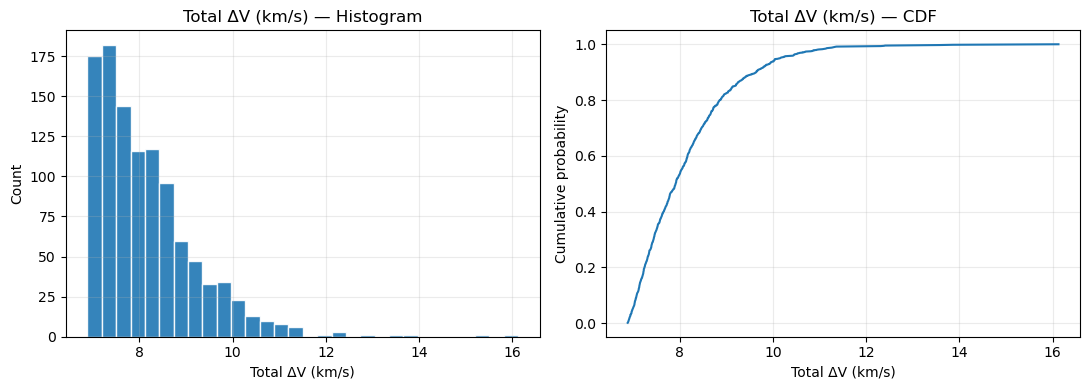

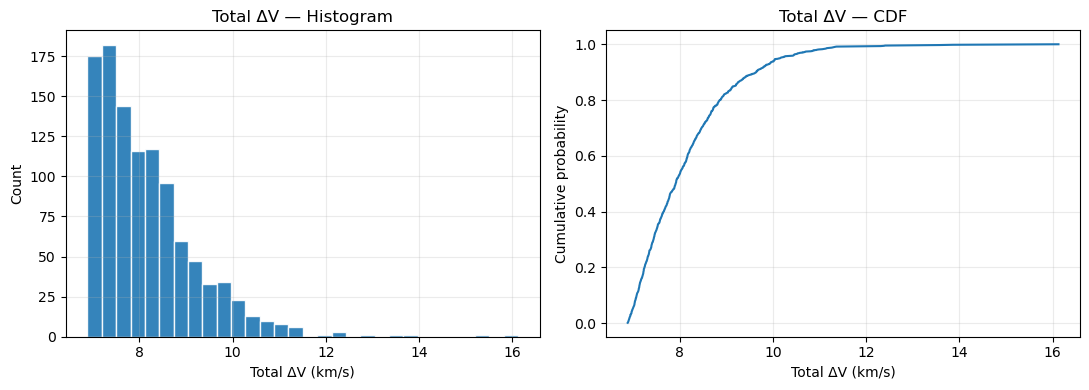

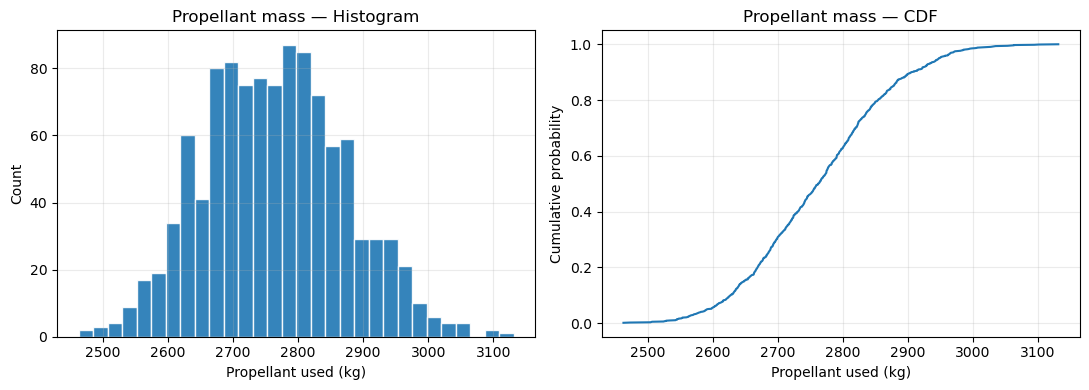

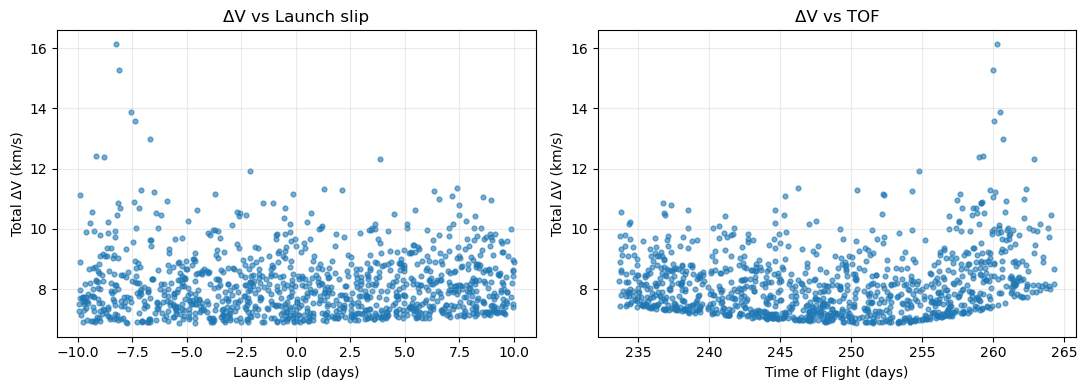

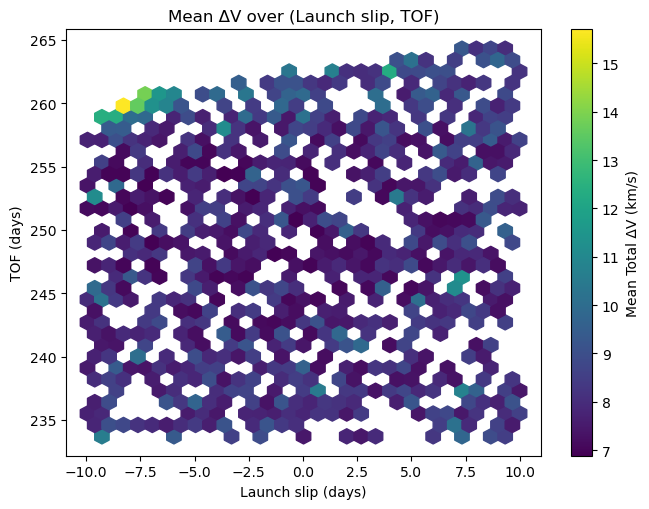


=== Variable Importance (target = Total ΔV (km/s)) ===
Rank | Variable                         | ρ_spearman  β_std     permΔRMSE  | Composite
-----+----------------------------------+-----------------------------------+----------
   1 | Arrival magnitude 1σ             |    +0.633   +0.623     +0.485 |  0.580
   2 | Injection magnitude 1σ           |    +0.488   +0.524     +0.368 |  0.460
   3 | Time of flight                   |    +0.088   +0.138     +0.033 |  0.086
   4 | Launch slip                      |    +0.059   -0.062     +0.007 |  0.043
   5 | TCM-2 magnitude                  |    +0.033   +0.040     +0.003 |  0.025
   6 | Start mass at injection          |    +0.034   +0.015     +0.000 |  0.016
   7 | TCM-1 magnitude                  |    +0.012   +0.011     +0.000 |  0.008
   8 | Injection pointing 1σ            |    +0.017   -0.006     +0.000 |  0.008


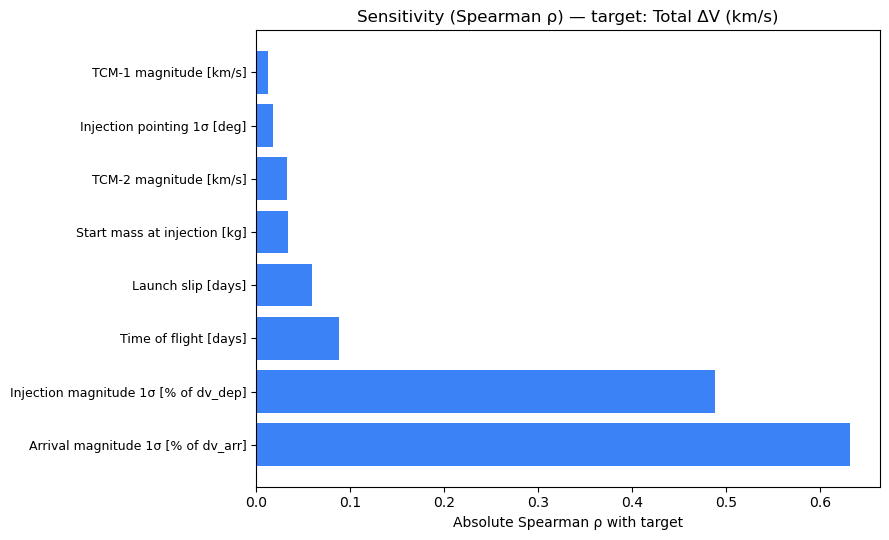

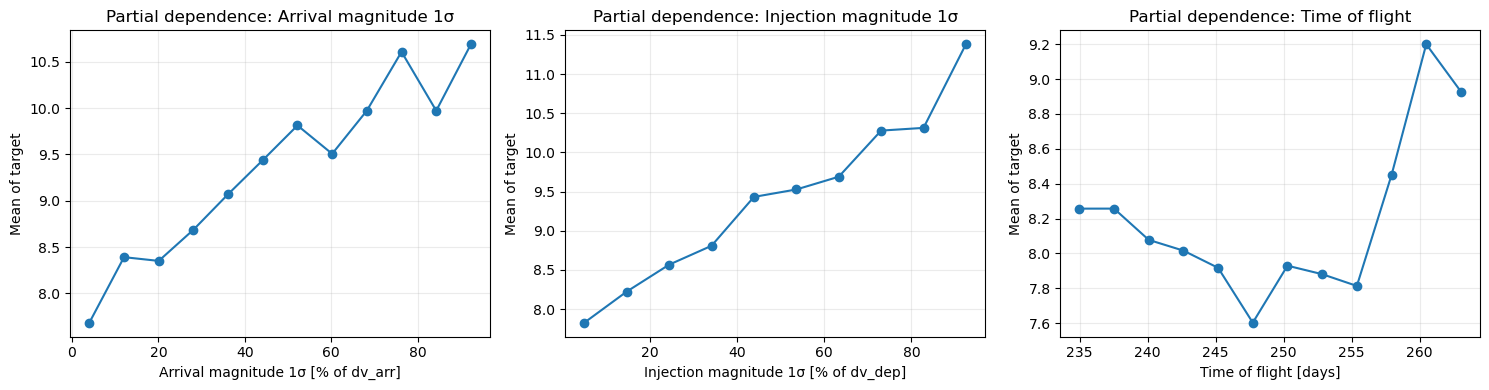


Done. Tip: switch Config.target_metric to 'c3' or 'propellant_kg' to re-rank variables against those outcomes.


In [6]:

import math
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import time
from astropy.coordinates import solar_system_ephemeris

from poliastro.bodies import Sun, Earth, Mars
from poliastro.ephem import Ephem
from poliastro.twobody import Orbit

# stumpff + norm (lightweight helpers from poliastro)
from poliastro._math.special import stumpff_c2 as c2, stumpff_c3 as c3
from poliastro._math.linalg import norm

solar_system_ephemeris.set("jpl")

# Physics constants
G0 = 9.80665  # m/s^2


def ephem_state(body, when_tdb):
    eph = Ephem.from_body(body, when_tdb)
    return Orbit.from_ephem(Sun, eph, when_tdb)


def rocket_eq_delta_m(m0, dv_kms, Isp_s):
    """Propellant used (kg) for ΔV at given Isp and initial mass m0 (kg)."""
    dv_ms = float(dv_kms) * 1000.0
    if Isp_s <= 0:
        return 0.0
    mf = m0 * math.exp(-dv_ms / (Isp_s * G0))
    return max(0.0, m0 - mf)


def ranks(x):
    """Rank-transform for Spearman correlation (no SciPy needed)."""
    x = np.asarray(x)
    order = np.argsort(x)
    r = np.empty_like(order, dtype=float)
    r[order] = np.arange(len(x))
    return r


# Lambert (universal variable, single-rev)
def lambert_universal(mu_km3_s2, r1_km, r2_km, tof_s, tol=1e-8, itmax=200):
    r1 = np.array(r1_km, dtype=float)
    r2 = np.array(r2_km, dtype=float)

    r1n = norm(r1)
    r2n = norm(r2)
    cos_dnu = np.clip((r1 @ r2) / (r1n * r2n), -1.0, 1.0)
    dnu = math.acos(cos_dnu)
    A = math.sin(dnu) * math.sqrt(r1n * r2n / (1 - math.cos(dnu)))
    if abs(A) < 1e-14:
        raise RuntimeError("Lambert singular geometry (θ≈0 or 180°).")

    def y_of(z):
        Cz = c2(z)
        Sz = c3(z)
        if Cz <= 0:
            return np.inf
        return r1n + r2n + A * ((z * Sz - 1.0) / math.sqrt(Cz))

    def tof_of(z):
        y = y_of(z)
        if y <= 0 or not np.isfinite(y):
            return np.inf
        Cz = c2(z)
        Sz = c3(z)
        chi = math.sqrt(y / Cz)
        return (chi**3 * Sz + A * math.sqrt(y)) / math.sqrt(mu_km3_s2)

    z_lo, z_hi, z = -np.pi**2, np.pi**2, 0.0
    tries = 0
    while y_of(z) <= 0 and tries < 100:
        z += 0.1
        tries += 1

    t_target = float(tof_s)
    it = 0
    while it < max(itmax, 100):
        y = y_of(z)
        if y <= 0 or not np.isfinite(y):
            z_lo = z
            z = 0.5 * (z_lo + z_hi)
            it += 1
            continue
        t_new = tof_of(z)
        if t_new != np.inf and abs((t_new - t_target) / t_target) < tol:
            break
        if t_new < t_target:
            z_lo = z
        else:
            z_hi = z
        z = 0.5 * (z_lo + z_hi)
        it += 1
    else:
        raise RuntimeError("Lambert did not converge.")

    Cz = c2(z)
    y = y_of(z)
    f = 1.0 - y / r1n
    g = A * math.sqrt(y / mu_km3_s2)
    gdot = 1.0 - y / r2n

    v1 = (r2 - f * r1) / g
    v2 = (gdot * r2 - r1) / g
    return v1, v2  # km/s


#  Monte Carlo configuration 
class Config:
    # Nominal MSL-like window (edit freely)
    dep_iso = "2011-11-26 15:02"
    arr_iso = "2012-08-06 05:17"

    # Vehicle / propulsion assumptions
    Isp_main = 320.0  # s  (main burns)
    Isp_tcm = 300.0   # s  (TCMs)
    m0_injection = 3000.0  # kg at departure

    # Uncertainty model
    launch_slip_days = (-10.0, 10.0)   # Uniform [d]
    tof_slip_days = (-20.0, 20.0)      # Uniform [d]
    inj_mag_sigma_pct = 0.3            # 1-σ, % of dv_dep  (normal, ≥0)
    inj_point_sigma_deg = 0.2          # 1-σ, deg          (normal, |.|)
    tcm1_mu, tcm1_sigma = 30.0, 10.0   # m/s (normal, truncated at 0)
    tcm2_mu, tcm2_sigma = 20.0, 8.0    # m/s
    arr_mag_sigma_pct = 0.3            # 1-σ, %            (normal, ≥0)
    mass_sigma_pct = 3.0               # 1-σ, %            (normal)

    # Trials
    N = 1500
    seed = 7

    # Risk thresholds (edit to your allocations)
    dv_allocation = 6.2   # km/s Total ΔV budget
    c3_allocation = 13.0  # km^2/s^2 C3 budget

    # Target metric for importance ranking: choose from {"dv_total", "c3", "propellant_kg"}
    target_metric = "dv_total"


#  One Monte Carlo trial 
def run_trial(cfg: Config, rng: np.random.Generator):
    dep0 = time.Time(cfg.dep_iso, scale="utc").tdb
    arr0 = time.Time(cfg.arr_iso, scale="utc").tdb
    tof0_days = (arr0 - dep0).to_value(u.day)

    dep_slip = rng.uniform(*cfg.launch_slip_days)
    tof_slip = rng.uniform(*cfg.tof_slip_days)
    dep = dep0 + dep_slip * u.day
    arr = dep + (tof0_days + tof_slip) * u.day

    inj_mag_pct = max(0.0, rng.normal(0.0, cfg.inj_mag_sigma_pct))
    inj_point_deg = abs(rng.normal(0.0, cfg.inj_point_sigma_deg))

    tcm1 = max(0.0, rng.normal(cfg.tcm1_mu, cfg.tcm1_sigma)) / 1000.0  # km/s
    tcm2 = max(0.0, rng.normal(cfg.tcm2_mu, cfg.tcm2_sigma)) / 1000.0  # km/s
    arr_mag_pct = max(0.0, rng.normal(0.0, cfg.arr_mag_sigma_pct))

    m0 = max(1.0, rng.normal(cfg.m0_injection, cfg.m0_injection * cfg.mass_sigma_pct / 100.0))

    earth = ephem_state(Earth, dep)
    mars = ephem_state(Mars, arr)

    mu = earth.attractor.k.to_value(u.km**3 / u.s**2)
    r1 = earth.r.to_value(u.km)
    r2 = mars.r.to_value(u.km)
    tof_s = (arr - dep).to_value(u.s)

    try:
        v1, v2 = lambert_universal(mu, r1, r2, tof_s)
    except Exception:
        return None

    dv_dep_nom = norm(v1 - earth.v.to_value(u.km / u.s))
    dv_arr_nom = norm(mars.v.to_value(u.km / u.s) - v2)

    theta = math.radians(inj_point_deg)
    dv_inj_extra = dv_dep_nom * inj_mag_pct + 0.5 * dv_dep_nom * (theta**2)
    dv_dep = dv_dep_nom + dv_inj_extra
    dv_arr = dv_arr_nom * (1.0 + arr_mag_pct)
    tcm_sum = tcm1 + tcm2

    dv_total = dv_dep + dv_arr + tcm_sum
    c3_val = dv_dep**2

    # Propellant along sequence
    m = m0
    used = 0.0
    for dv_kms, Isp in [(dv_dep, cfg.Isp_main), (tcm1, cfg.Isp_tcm),
                        (tcm2, cfg.Isp_tcm), (dv_arr, cfg.Isp_main)]:
        dm = rocket_eq_delta_m(m, dv_kms, Isp)
        used += dm
        m -= dm

    return {
        # Inputs (as-sampled)
        "dep_slip_d": dep_slip,
        "tof_d": (arr - dep).to_value(u.day),
        "inj_mag_pct": inj_mag_pct * 100.0,
        "inj_point_deg": inj_point_deg,
        "tcm1_kms": tcm1,
        "tcm2_kms": tcm2,
        "arr_mag_pct": arr_mag_pct * 100.0,
        "m0": m0,
        # Outputs
        "dv_dep": dv_dep,
        "dv_arr": dv_arr,
        "tcm_sum": tcm_sum,
        "dv_total": dv_total,
        "c3": c3_val,
        "propellant_kg": used,
    }


def run_monte_carlo(cfg: Config):
    rng = np.random.default_rng(cfg.seed)
    rows = []
    for _ in range(cfg.N):
        r = run_trial(cfg, rng)
        if r is not None:
            rows.append(r)
    if not rows:
        raise RuntimeError("No feasible trials.")
    return {k: np.array([row[k] for row in rows]) for k in rows[0].keys()}


# Visualisations 
def plot_hist_cdf(data, key, xlabel, title, nbins=30):
    x = data[key]
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    ax[0].hist(x, bins=nbins, alpha=0.9, edgecolor="white")
    ax[0].set_xlabel(xlabel); ax[0].set_ylabel("Count")
    ax[0].set_title(f"{title} — Histogram"); ax[0].grid(alpha=0.25)
    xs = np.sort(x); cdf = np.arange(1, len(xs) + 1) / len(xs)
    ax[1].plot(xs, cdf)
    ax[1].set_xlabel(xlabel); ax[1].set_ylabel("Cumulative probability")
    ax[1].set_title(f"{title} — CDF"); ax[1].grid(alpha=0.25)
    plt.tight_layout(); plt.show()


def plot_scatter(data):
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    ax[0].scatter(data["dep_slip_d"], data["dv_total"], s=12, alpha=0.6)
    ax[0].set_xlabel("Launch slip (days)"); ax[0].set_ylabel("Total ΔV (km/s)")
    ax[0].set_title("ΔV vs Launch slip"); ax[0].grid(alpha=0.25)

    ax[1].scatter(data["tof_d"], data["dv_total"], s=12, alpha=0.6)
    ax[1].set_xlabel("Time of Flight (days)"); ax[1].set_ylabel("Total ΔV (km/s)")
    ax[1].set_title("ΔV vs TOF"); ax[1].grid(alpha=0.25)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6.8, 5.2))
    hb = plt.hexbin(data["dep_slip_d"], data["tof_d"], C=data["dv_total"],
                    gridsize=30, reduce_C_function=np.mean, cmap="viridis")
    plt.xlabel("Launch slip (days)"); plt.ylabel("TOF (days)")
    cb = plt.colorbar(hb); cb.set_label("Mean Total ΔV (km/s)")
    plt.title("Mean ΔV over (Launch slip, TOF)")
    plt.tight_layout(); plt.show()


# Variable importance 
def variable_catalog():
    """Human-readable catalog of inputs affecting the mission."""
    items = [
        ("dep_slip_d",   "Launch slip", "days", "Calendar shift of launch"),
        ("tof_d",        "Time of flight", "days", "Cruise duration Earth→Mars"),
        ("inj_mag_pct",  "Injection magnitude 1σ", "% of dv_dep", "Execution scatter in DV magnitude at departure"),
        ("inj_point_deg","Injection pointing 1σ", "deg", "Guidance/pointing scatter at departure (small-angle penalty)"),
        ("tcm1_kms",     "TCM-1 magnitude", "km/s", "First deterministic retargeting/correction"),
        ("tcm2_kms",     "TCM-2 magnitude", "km/s", "Second deterministic retargeting/correction"),
        ("arr_mag_pct",  "Arrival magnitude 1σ", "% of dv_arr", "Execution scatter in Mars capture DV"),
        ("m0",           "Start mass at injection", "kg", "Affects propellant, not DV directly"),
    ]
    return items


def importance_spearman(data, target_key):
    y = data[target_key]
    ry = ranks(y)
    out = []
    for k, nice, unit, _ in variable_catalog():
        rx = ranks(data[k])
        rho = float(np.corrcoef(ry, rx)[0, 1])
        out.append((k, nice, unit, rho, abs(rho)))
    # sort by |rho|
    return sorted(out, key=lambda x: x[-1], reverse=True)


def _zscore(arr):
    m = np.mean(arr); s = np.std(arr)
    if s == 0: s = 1.0
    return (arr - m) / s


def importance_linear_beta(data, target_key):
    # Standardised linear regression y ~ X (no SciPy)
    y = _zscore(data[target_key])
    Xcols = []
    meta = []
    for k, nice, unit, _ in variable_catalog():
        Xcols.append(_zscore(data[k]))
        meta.append((k, nice, unit))
    X = np.vstack(Xcols).T  # [N, p]
    # Add intercept if you want (not needed for standardised betas):
    # Solve least squares
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    out = []
    for (k, nice, unit), b in zip(meta, beta):
        out.append((k, nice, unit, float(b), abs(float(b))))
    return sorted(out, key=lambda x: x[-1], reverse=True)


def importance_permutation(data, target_key, n_perm=50, rng=None):
    """Permutation importance using the standardised linear model as predictor."""
    if rng is None:
        rng = np.random.default_rng(0)

    # Fit standardised linear model
    y = _zscore(data[target_key])
    Xcols = []
    keys = []
    meta = []
    for k, nice, unit, _ in variable_catalog():
        Xcols.append(_zscore(data[k])); keys.append(k); meta.append((k, nice, unit))
    X = np.vstack(Xcols).T
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    yhat = X @ beta
    baseline_rmse = math.sqrt(np.mean((y - yhat) ** 2))

    out = []
    for j, (k, nice, unit) in enumerate(meta):
        deltas = []
        for _ in range(n_perm):
            Xp = X.copy()
            rng.shuffle(Xp[:, j])
            yhat_p = Xp @ beta
            rmse_p = math.sqrt(np.mean((y - yhat_p) ** 2))
            deltas.append(rmse_p - baseline_rmse)
        mean_delta = float(np.mean(deltas))
        out.append((k, nice, unit, mean_delta, abs(mean_delta)))
    return sorted(out, key=lambda x: x[-1], reverse=True)


def show_importance_table(spear, beta, perm, target_label):
    """Combine the three rankings into one printed table."""
    # Build a dict keyed by k with metrics
    keys = [k for k, *_ in variable_catalog()]
    rows = []
    for k, nice, unit, *_ in variable_catalog():
        rho = next((r[3] for r in spear if r[0]==k), np.nan)
        b   = next((r[3] for r in beta  if r[0]==k), np.nan)
        pi  = next((r[3] for r in perm  if r[0]==k), np.nan)
        score = np.nanmean([abs(rho), abs(b), abs(pi)])  # simple composite
        rows.append((k, nice, unit, rho, b, pi, score))
    rows.sort(key=lambda x: x[-1], reverse=True)

    print(f"\n=== Variable Importance (target = {target_label}) ===")
    print("Rank | Variable                         | ρ_spearman  β_std     permΔRMSE  | Composite")
    print("-----+----------------------------------+-----------------------------------+----------")
    for i, r in enumerate(rows, start=1):
        print(f"{i:>4} | {r[1]:<32} | {r[3]:>+9.3f}  {r[4]:>+7.3f}   {r[5]:>+8.3f} |  {r[6]:.3f}")

    return rows  # for plotting top-k partial dependence


def plot_tornado_from_spearman(spear, title):
    labels = [f"{r[1]} [{r[2]}]" for r in spear]
    vals = [abs(r[3]) for r in spear]
    order = np.argsort(vals)[::-1]
    labels = [labels[i] for i in order]
    vals = [vals[i] for i in order]

    plt.figure(figsize=(9, 5.5))
    plt.barh(range(len(vals))[::-1], vals[::-1], color="#3b82f6")
    plt.yticks(range(len(labels))[::-1], labels[::-1], fontsize=9)
    plt.xlabel("Absolute Spearman ρ with target")
    plt.title(title)
    plt.tight_layout(); plt.show()


def plot_partial_dependence(data, target_key, ranked_rows, top_k=3, bins=12):
    """1D partial dependence (bin-mean) for top-k variables from combined table."""
    y = data[target_key]
    fig, axs = plt.subplots(1, top_k, figsize=(5 * top_k, 4), squeeze=False)
    axs = axs[0]
    for i in range(top_k):
        k = ranked_rows[i][0]
        x = data[k]
        # bin
        edges = np.linspace(np.min(x), np.max(x), bins + 1)
        centers = 0.5 * (edges[:-1] + edges[1:])
        idx = np.digitize(x, edges) - 1
        ymean = [np.mean(y[idx == b]) if np.any(idx == b) else np.nan for b in range(bins)]
        axs[i].plot(centers, ymean, marker="o")
        axs[i].set_xlabel(f"{ranked_rows[i][1]} [{ranked_rows[i][2]}]")
        axs[i].set_ylabel("Mean of target")
        axs[i].grid(alpha=0.25)
        axs[i].set_title(f"Partial dependence: {ranked_rows[i][1]}")
    plt.tight_layout(); plt.show()


def report_stats(cfg: Config, data):
    def pct(v, p): return float(np.percentile(v, p))
    dv, c3v, prop = data["dv_total"], data["c3"], data["propellant_kg"]

    print("\n=== Monte Carlo Summary (Earth→Mars) ===")
    print(f"Trials (feasible): {len(dv)}")
    print(f"ΔV total [km/s]:  mean={np.mean(dv):.3f}  median={np.median(dv):.3f}  "
          f"P10={pct(dv,10):.3f}  P90={pct(dv,90):.3f}")
    print(f"C3 [km^2/s^2]:     mean={np.mean(c3v):.3f}  median={np.median(c3v):.3f}  "
          f"P10={pct(c3v,10):.3f}  P90={pct(c3v,90):.3f}")
    print(f"Propellant [kg]:   mean={np.mean(prop):.1f}  median={np.median(prop):.1f}  "
          f"P10={pct(prop,10):.1f}  P90={pct(prop,90):.1f}")

    p_exceed_dv = np.mean(dv > cfg.dv_allocation)
    p_exceed_c3 = np.mean(c3v > cfg.c3_allocation)
    print(f"Risk: P(ΔV > {cfg.dv_allocation:.2f} km/s)   = {100*p_exceed_dv:.1f}%")
    print(f"Risk: P(C3 > {cfg.c3_allocation:.2f} km^2/s^2) = {100*p_exceed_c3:.1f}%")


def print_variable_catalog():
    print("\n=== Inputs (uncertain variables) ===")
    for k, nice, unit, desc in variable_catalog():
        print(f"- {nice:<22} [{unit:>8}] : {desc}")


def main():
    cfg = Config()

    print_variable_catalog()
    print("\nRunning Monte Carlo…")
    data = run_monte_carlo(cfg)

    # Summary & key visualisations
    report_stats(cfg, data)
    target = cfg.target_metric
    target_label = {"dv_total": "Total ΔV (km/s)", "c3": "C3 (km^2/s^2)", "propellant_kg": "Propellant (kg)"}[target]

    # Distributions
    plot_hist_cdf(data, target, target_label, target_label)
    plot_hist_cdf(data, "dv_total", "Total ΔV (km/s)", "Total ΔV")
    plot_hist_cdf(data, "propellant_kg", "Propellant used (kg)", "Propellant mass")

    # Relationships
    plot_scatter(data)

    # Importance (three ways)
    spear = importance_spearman(data, target)
    beta  = importance_linear_beta(data, target)
    perm  = importance_permutation(data, target, n_perm=60, rng=np.random.default_rng(1))

    combined_rows = show_importance_table(spear, beta, perm, target_label)

    # Tornado from Spearman
    plot_tornado_from_spearman(spear, f"Sensitivity (Spearman ρ) — target: {target_label}")

    # Partial dependence for top 3 drivers from combined score
    plot_partial_dependence(data, target, combined_rows, top_k=3, bins=12)

    print("\nDone. Tip: switch Config.target_metric to 'c3' or 'propellant_kg' "
          "to re-rank variables against those outcomes.")


if __name__ == "__main__":
    main()
